<a href="https://colab.research.google.com/github/adamzki99/nlp-zlatan/blob/feature%2Fall-MiniLM-L6-v2-implementation/nlp_zlatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

This notebook is designed to be used together with Google Colab. We start by connecting the notebook to our personal Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Be careful to check the you have the same filepath for the dataset in your drive

In [2]:
%cd /content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia

/content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia


# all-MiniLM-L6-v2

This implementation is based on the all-MiniLM-L6-v2 model which is available from [Huggingface](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

The all-MiniLM-L6-v2 is a sentence-transformers model. It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search. This is a later model compared to the one showed in one of the tutorials, but is used more or less in the same way.


We have selected to pick a BERT model as we wanted to explore the posibility of creating a "vector database". The use-case is as follows:

From a natural user input, we want to retrive the correct Wikipedia passage. So that the input from the user is as small as possible. 

The reduction of data input comes from the exlusion of topics etc..  

## Data extraction

The dataset used is very nested, hard to navigate and just difficult to wrap ones head around. So it is recommended to see this [resource](https://parl.ai/projects/wizard_of_wikipedia/) to get a better undersatnding.

In [3]:
import json

with open('data.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


Use the following keys to double check with the [resource](https://parl.ai/projects/wizard_of_wikipedia/) that you have loaded in the right dataset.

In [4]:
data[0]['dialog'][0].keys()

dict_keys(['speaker', 'text', 'checked_sentence', 'checked_passage', 'retrieved_passages', 'retrieved_topics'])

We split up the data into a 80/20 split. We use 80% of the original dataset to perform fine-tuing of the all-MiniLM-L6-v2, the rest is then used for validating the reslut.

We aim to have the model being able to search the vector-space with new input and still being able to find the correct Wiki-passage.

It is important to note that this is a best case scenario as the input is generated from text that is present in the Wiki-passage.

In [5]:
import pandas as pd

data_extract_train = {
    "chosen_topic": [],
    "speaker_passage": [],
    "checked_sentence": [],
    "chosen_topic_passage": []
}

data_extract_test = {
    "chosen_topic": [],
    "speaker_passage": [],
    "checked_sentence": [],
    "chosen_topic_passage": []
}

for i, conversation in enumerate(data):

  for j, dialog in enumerate(conversation['dialog']):    

    if "Wizard" in dialog['speaker']:

      checked_sentence = list(dialog['checked_sentence'].values())

      if "no_passages_used" not in checked_sentence:

        if j % 4 == 0:

          data_extract_test['chosen_topic'].append(conversation['chosen_topic'])
          data_extract_test['speaker_passage'].append(dialog['text'])
          data_extract_test['checked_sentence'].append(checked_sentence)
          data_extract_test['chosen_topic_passage'].append(conversation['chosen_topic_passage'])

        else:
      
          data_extract_train['chosen_topic'].append(conversation['chosen_topic'])
          data_extract_train['speaker_passage'].append(dialog['text'])
          data_extract_train['checked_sentence'].append(checked_sentence)
          data_extract_train['chosen_topic_passage'].append(conversation['chosen_topic_passage'])

extract_train_df = pd.DataFrame(data_extract_train)

extract_test_df = pd.DataFrame(data_extract_test)

extract_test_df

,chosen_topic,speaker_passage,checked_sentence,chosen_topic_passage
0,Science fiction,I think science fiction is an amazing genre fo...,[Science fiction (often shortened to SF or sci...,[Science fiction (often shortened to SF or sci...
1,Science fiction,"It's not quite sci-fi, but my favorite version...",[The central premise for these stories oftenti...,[Science fiction (often shortened to SF or sci...
2,Romance (love),I don't know how to be romantic. I have troubl...,[Romance is the expressive and pleasurable fee...,[Romance is the expressive and pleasurable fee...
3,Romance (love),For sure. Romantic love is relative but usuall...,"[Romantic love is a relative term, but general...",[Romance is the expressive and pleasurable fee...
4,Romance (love),Good point. Romance is associated with perfect...,"[This feeling is associated with, but does not...",[Romance is the expressive and pleasurable fee...
...,...,...,...,...
25983,Kendrick Lamar,Kendrick Lamar is great! He is a rapper,"[Kendrick Lamar Duckworth (born June 17, 1987)...","[Kendrick Lamar Duckworth (born June 17, 1987)..."
25984,Kendrick Lamar,"It is not, but he is very acclaimed in the gen...","[His critically acclaimed third album ""To Pimp...","[Kendrick Lamar Duckworth (born June 17, 1987)..."
25985,Skiing,I knew skiing was a winter sport but I never t...,"[Skiing can be a means of transport, a recreat...","[Skiing can be a means of transport, a recreat..."
25986,Skiing,It seems that it may also have been practiced ...,[Although modern skiing has evolved from begin...,"[Skiing can be a means of transport, a recreat..."


### Reducing the size

The size of the dataset is too big for the amount of available VRAM on the GPU. Therefor we need to reduce the size of the extracted dataset.

We also found that using more data will just result in overfitting the model.

In [6]:
testing_size = len(extract_test_df.index)*0.04
testing_size = int(testing_size)

training_size = len(extract_train_df.index)*0.04
training_size = int(training_size)

print("Ratio %:", testing_size/training_size * 100)

Ratio %: 37.823079723334544


In [7]:
extract_test_df = extract_test_df.sample(testing_size)
extract_test_df

,chosen_topic,speaker_passage,checked_sentence,chosen_topic_passage
25587,Bowling,target is usually to knock over pins at the en...,"[In pin bowling variations, the target is usua...",[Bowling is a sport or leisure activity in whi...
10590,Back pain,"No, it originates in my spine. Luckily the pa...","[Episodes of back pain may be acute, sub-acute...","[Back pain is pain in any region of the back.,..."
19425,"Austin, Texas",He led the colonization of the region bringing...,"[Known as the ""Father of Texas"", and the found...",[Austin () is the capital of the U.S. state of...
5458,Husky,"Still Alaska because husky"" is recorded from 1...","[The use of ""husky"" is recorded from 1852 for ...",[Husky is a general name for a sled-type of do...
20029,Linkin Park,"I love the rock band, Linkin Park.",[Linkin Park is an American rock band from Ago...,[Linkin Park is an American rock band from Ago...
...,...,...,...,...
9850,Barbie,I used to have the biggest collection of Barbi...,[Barbie is the figurehead of a brand of Mattel...,[Barbie is a fashion doll manufactured by the ...
21616,Veganism,People argue that it is not necessary to survi...,[The most commonly given ethical objection to ...,[Veganism is both the practice of abstaining f...
3825,Desert,"I'm not sure of exact heat in general, but the...","[It is a temperate desert with hot, dry summer...",[A desert is a barren area of landscape where ...
4247,The Lord of the Rings,"Of course not, it's an epic high fantasy novel...",[The Lord of the Rings is an epic high fantasy...,[The Lord of the Rings is an epic high fantasy...


In [8]:
extract_train_df = extract_train_df.sample(training_size)
extract_train_df

,chosen_topic,speaker_passage,checked_sentence,chosen_topic_passage
48573,Van Halen,He was the primary lead vocalist and lyricist ...,"[Ronald Belford ""Bon"" Scott (9 July 1946 – 19 ...",[Van Halen is an American hard rock band forme...
35078,India,"It is very big! In fact, it is the seventh la...","[It is the seventh-largest country by area, th...","[India, officially the Republic of India (""Bhā..."
24805,Algeria,"Wow! We've visited before, since a cousin of m...",[With its rich and unique cultural and archite...,"[Algeria ( '; '; ), officially the People's De..."
21315,Frank Ocean,"Did you like his studio album ""Channel Orange""...","[His debut studio album, ""Channel Orange"", was...",[Frank Ocean (born Christopher Edwin Breaux; O...
1776,Brewery,"well, canada beer is good, it was introduced ...",[Beer in Canada was introduced by European set...,[A brewery or brewing company is a business th...
...,...,...,...,...
11859,Hair,Yes; I feel that it's coming back for sure. Wh...,[Curly hair also has its own variation ranging...,[Hair is a protein filament that grows from fo...
8174,Chicken,"She keeps poultry? She eats the meat too, right?",[Poultry () are domesticated birds kept by hum...,"[The chicken (""Gallus gallus domesticus"") is a..."
54371,Ford Mustang,Yeah! Though Mustang has undergone several tra...,[The Mustang has undergone several transformat...,[The Ford Mustang is an American car manufactu...
66215,Hot dog,They basically grind all this meat and fat and...,[The hot dog became closely associated with ba...,"[A hot dog (also spelled hotdog), also known a..."


## Finetuning the model

As we can see from the pevious output, the dataset is very huge. Too big to fit on our GPU V-RAM. 

In [9]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.8 MB/s eta 0:00:00


In [10]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In order to fine-tune the model we need to construct sentence pairs. These pairs consists of a "user-input" and a sentence from the Wiki-passage

As stated earlier, the "user-input" is a genereated human-like input. The input from is genereated from the same sentence as the Wiki-passage which it is matched with. 

We note that this isn't the best case senario, as it can be interperted as the dataset is traning it self and creates a circle dependence. But we see it as being a "optimal" scenario instead.

In [11]:
def data_division(dataframe, sample_size:int):

  selected_sentences = []
  selected_conversation_topics = []

  for c, row in dataframe.sample(sample_size).iterrows():
    
    selected_conversation_topics.append(row['chosen_topic'])

    for resp in row['checked_sentence']:
      pair = (row['speaker_passage'], resp)
      selected_sentences.append(pair)

  return selected_sentences, selected_conversation_topics

In [12]:
selected_sentences_training, conversation_topics_traning = data_division(extract_train_df, len(extract_train_df.index))

In [13]:
selected_sentences_training[0]

('From largest to smallest, the three waterfalls are the Horseshoe Falls, the American Falls and the Bridal Veil Falls.',
 'Yes, from largest to smalled, the three are Horseshoe Falls, American Falls and Bridal Veil Falls.')

Back to training the model...

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# Move model to GPU
model.to(device)

cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

## Using mean-pooling

Becasue of the variable-length of the input we need to transform the input into a fixed-length representation so we can pass it to our model for traning.

The process involves taking the average of all the token embeddings in the sequence. More or less, this is achieved by summing up the embeddings and dividing the sum by the total number of tokens in the sequence.

Note that mean-pooling does not consider the positional information or the relative importance of individual tokens within the sequence. In order to combat this we make use of a attetion mask inorder to highlight some importance in the embedding.

The **mean_pooling** function performs mean pooling on token embeddings while considering an attention mask for correct averaging. It takes *model_output* and *attention_mask* as inputs.

The function first extracts the token embeddings from *model_output*. It then expands the attention mask to match the dimensions of the token embeddings. The expanded mask is used to mask out the embeddings that should be ignored.

Next, the masked token embeddings are summed along the second dimension (axis 1) to obtain the sum of the embeddings for each token. The attention mask is also summed along the second dimension and clamped to avoid division by zero.

Finally, the masked token embeddings are divided by the clamped attention mask sum to compute the mean pooling. The resulting mean-pooled embeddings are returned.

In [17]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

The embedding is performed in the same way as desrcibes in the documentation for the all-MiniLM-L6-v2 model. One step that has been left out is the normalizaiton of the embedding. 

The normalization whould provide a list of benefits, such as: improved training and stability, reducing dimensionality, alignment of embedding spaces.

The reason that we whould like to perform normalization is to have similarity of meaurements when evaluating the performance of the model.

In [15]:
def perform_embedding(documents:list, device, model):

  encoded_documents = tokenizer(documents, padding=True, truncation=True, return_tensors='pt')

  encoded_documents.to(device)
  with torch.no_grad():
      model_output_documents = model(**encoded_documents)

  # Perform pooling
  embedding = mean_pooling(model_output_documents, encoded_documents['attention_mask'])

  # Normalize embedding
  embedding = F.normalize(embedding, p=2, dim=1)

  return embedding

In [18]:
sentence_embeddings = perform_embedding(documents = selected_sentences_training, device = device, model = model)

## Visualizing Cluster with Hypertools

In order to get a better understanding of the dataset we will use Hypertools to transform the very high dimensional space into a something we can understand. 

We will generate a 3-dimensional wiev of the embeddings and color in correspondence to k-mean clusters. The amount of clusters corresponds to the amount of topics that is included in the dataset.

In [19]:
%pip install hypertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=3acf7a4b921a4a353dff0f5d497a7ba3c0dced0985a2a47c336bfb0fedf87c95
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=1875074c4844c2cc3fdaa835f4adef13f58331cbd64dc677e2ec3f8b05c555cf
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Number of clusters: 900


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hypertools/plot/plot.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwargs[kwarg]=np.array(kwargs[kwarg])


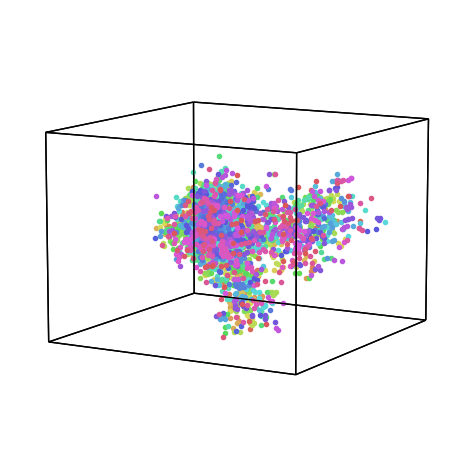

In [20]:
import hypertools as hyp

n_clusters = len(set(conversation_topics_traning))

print("Number of clusters:", n_clusters)

hyp.plot(sentence_embeddings.cpu().detach().numpy(), '.', n_clusters = n_clusters)

## Model usage

In [21]:
%pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp310-cp310-linux_x86_64.whl size=2119773 sha256=be55a682cc81d364a2e03cb8ad54aaec0ed2e232d6804c711d599ee38c048dcd
  Stored in directory: /root/.cache/pip/wheels/8a/ae/ec/235a682e0041fbaeee389843670581ec6c66872db856dfa9a4
Successfully built hnswlib


In order to search the embedding vector space we perform **k-nearest neighbors** (KNN) query. This works by creating a index using hnswlib, this is to improve the efficiency of the search.

We then perform the embedding process on the query, which in our case is the *speaker_passage*, and calculates the absolute distance to the *k* closest elements in the index.

In [22]:
import hnswlib

# Create the HNSW index
index = hnswlib.Index(space='l2', dim=sentence_embeddings.shape[1])
index.init_index(max_elements=len(sentence_embeddings), ef_construction=200, M=16)

# Add sentence embeddings to the index
index.add_items(sentence_embeddings.cpu().numpy())

In [23]:
# Perform a similarity search
def search_embeddings(query:str, k, device, model):

  query_embedding = perform_embedding(documents=query, device=device, model=model)

  indexes, distances = index.knn_query(query_embedding.cpu(), k=k)

  return indexes[0], distances, query_embedding

Get a random speaker passage from the training dataset just to verify that we can use the model

In [24]:
random_message = list(extract_train_df.sample(1).to_dict()['speaker_passage'].values())[0]
message = [random_message]

message

['Not only are there hybrid electric cars, they actually have trucks and buses too!']

In [25]:
indexes, distances, query_embedding = search_embeddings(query=message, k=10, device=device, model=model)

print(indexes)

[ 734  367  841 1719  248    3  738  576 1414 2109]


In [26]:
query_subset = []

for i, ind in enumerate(indexes):
  print("Distance:", distances[0][i], "\t", selected_sentences_training[ind][1])
  query_subset.append(selected_sentences_training[ind])

Distance: 0.6035444 	 Not only are there hybrid electric cars, they actually have trucks and buses too!
Distance: 0.67148685 	 Yeah. I really want to get one of their hybrids which is the most common hybrid electric vehicle.
Distance: 0.73404145 	 I agree, I recommend you check out their line of hybrid electric vehicles as well.
Distance: 0.7583889 	 Well Hybrids can have many configurations but the most popular ones are powered by li-po batteries like the Tesla. 
Distance: 0.7679487 	 Yeah, they have been making those cars since 1997. Have they saved the world yet? lol
Distance: 0.8537218 	 A hybrid vehicle uses two or more distinct types of power
Distance: 0.9117221 	 It's really cool how hybrid energy vehicles can even use efficiency-improving technologies like regenerative brakes, so innovative!
Distance: 1.0663815 	 Really? I would so get a prius! It's the world's top selling hybrid with over 6 million units sold worldwide
Distance: 1.1215851 	 I do, as it is one of the world's to

## Looking at the result

Hypertools has it's limitations, so in order to check the how the results look in comparison to the query embedding we will use *matplotlib.pyplot*.

Note: Having a 2-dimensional representation of such a high dimensional vectorspace that the embeddings are isn't optimal. But it is better than nothing 😉.





In [27]:
selected_sentences_embedding = perform_embedding(documents=query_subset, device=device, model=model)

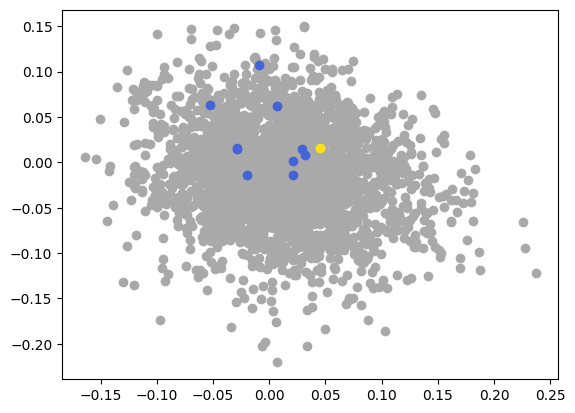

In [28]:
import matplotlib.pyplot as plt

plt.scatter(sentence_embeddings.cpu()[:,0] , sentence_embeddings.cpu()[:,1], c = '#a9a9a9')
plt.scatter(selected_sentences_embedding.cpu()[:,0] , selected_sentences_embedding.cpu()[:,1], c = '#4363d8')
plt.scatter(query_embedding.cpu()[:,0] , query_embedding.cpu()[:,1], color = '#ffe119')
plt.show()

## Testing the model

Now we have extracted the data, finetuned the model, and proved that it works once. Now we will have to prove that it works for more cases. 

Earlier we set aside 20% of the original data for testing. Becasue we are aming to create something that is working as a vector database, we want to have absolute accuracy and we are not interested in similarity. This is by we have a one-to-one comparison and not a BLEU-evaluation or similar.

In [29]:
# Get traning data
selected_sentences_testing, _ = data_division(extract_test_df, len(extract_test_df.index))

In [30]:
score = 0

for _, sentence_pair in enumerate(selected_sentences_testing):

  indexes, distances, query_embedding = search_embeddings(query=sentence_pair[0], k=1, device=device, model=model)

  results = []
  for _, i in enumerate(indexes):

    if i >= len(selected_sentences_testing):
      break

    results.append(selected_sentences_testing[i])
  

  if sentence_pair in results:
    score += 1
  
print("Accuracy:", score/len(selected_sentences_testing)*100, "%")

Accuracy: 0.1937984496124031 %


Thats is quite bad, how does it look if we use the traning data?

In [31]:
score = 0

for _, sentence_pair in enumerate(selected_sentences_training):

  indexes, distances, query_embedding = search_embeddings(query=sentence_pair[0], k=1, device=device, model=model)

  results = []
  for _, i in enumerate(indexes):

    if i >= len(selected_sentences_training):
      break

    results.append(selected_sentences_training[i])
  

  if sentence_pair in results:
    score += 1
  
print("Accuracy:", score/len(selected_sentences_training)*100, "%")

Accuracy: 82.64220183486238 %


## Finding the correct Wikipedia passage

To wrap it up, we want to find the correct Wiki-passage. This will be perfomed by just finding the passage in the bigger Wiki-passage and presenting it to the user.

In [32]:
def find_article(checked_sentence:str, data_extract):

  for passage in data_extract['chosen_topic_passage']:

    extracted_passage = ""

    for line in passage:
      extracted_passage = extracted_passage + " " + line

    if extracted_passage.find(checked_sentence) == 1:
      
      return extracted_passage

In [34]:
print("Sentence found:", query_subset[0][1])

# Here the whole data_extract_train is passed in, so it is a lot of uncessesary searing. 
complete_wiki_passge = find_article(checked_sentence=query_subset[0][1], data_extract=data_extract_train)

print("Wiki-passage:", complete_wiki_passge)

Sentence found: The most common form of HEV is the hybrid electric car, although hybrid electric trucks (pickups and tractors) and buses also exist.
Wiki-passage: None
